"In the previous exercise, you implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights we provided. In this exercise, you will implement the backpropagation algorithm to learn the parameters for the neural network."

**1.1 Visualizing the data**

We already did this for the previous Chapter. I will refer to our two notebooks in Ex3 folder. One quick note: Both this exercise and previous one refer to two identical data files in mat format. I won't copy these files again. How do we know if two files are identical? There are certain ways. One thing you can do is to check byte by byte through 'cmp' command. Another one is checking md5 sum. You can also check byte sizes of both files. md5sum offers the best compromise in terms of performance and reliability IMHO. I will apply this to see how it works. 

In [1]:
#import the relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(79728)
%matplotlib inline

In [2]:
!md5 ~/Downloads/machine-learning-ex4/ex4/ex4data1.mat  ~/Downloads/machine-learning-ex3/ex3/ex3data1.mat \
~/Downloads/machine-learning-ex4/ex4/ex4weights.mat ~/Downloads/machine-learning-ex3/ex3/ex3weights.mat 


MD5 (/Users/alperen/Downloads/machine-learning-ex4/ex4/ex4data1.mat) = 7a879161a0e63d7156b33e11511fad02
MD5 (/Users/alperen/Downloads/machine-learning-ex3/ex3/ex3data1.mat) = 7a879161a0e63d7156b33e11511fad02
MD5 (/Users/alperen/Downloads/machine-learning-ex4/ex4/ex4weights.mat) = 8dddd0bb5ecf0633232c70e29aac8807
MD5 (/Users/alperen/Downloads/machine-learning-ex3/ex3/ex3weights.mat) = 8dddd0bb5ecf0633232c70e29aac8807


As we can see both weights and data files given in  exercise files are identical. No need to replicate them.

In [3]:
import scipy.io as sio
weights = sio.loadmat('../data/ex3weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']
theta = [theta1, theta2]
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [4]:
data = sio.loadmat('../data/ex3data1.mat')
X = np.float64(data["X"])
y = data["y"] 
#I will need this only as an integer for now as I will use it as location input info 
# for the new output matrix I will create further down
X.shape, y.shape

((5000, 400), (5000, 1))

This time I will not add a column of ones to $X$ since we will have to add this column of ones at every level of network and it is best to incorporate the adding of ones to the functions that will use these layers as input. 

Let's illustrate some of the data we have. As we know from the description of the dataset, each entry in X consist of 400 numbers, each number illustrating the degree of darkness of each pixel. We can actually map this to a graph, or pic if you'd like through imshow function in matplotlib library.

We'll first draw 36 random entry to show. Then transform the one dimensional arrays of info into 20x20 square matrix. Finally we'll plot the each data row with a for loop.

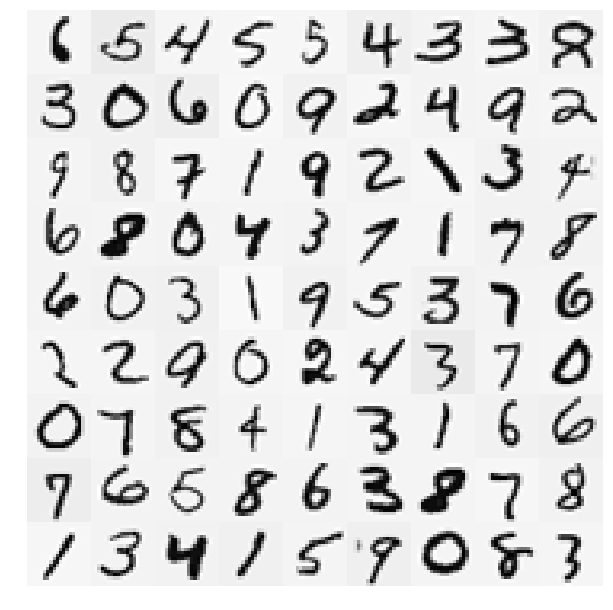

In [5]:
num_show = np.random.randint(0, 5001, 81)
#Create an array of random numbers that will be the numbers to be shown.
plt.figure(figsize=(8, 8))

for i in range(1, 82):
    some_digit = X[num_show[i-1]]
    #Pick the digit from X input matrix. It is one of the input arrays
    #Then reshape this array that has info on pixel darkness into a 
    #20x20 matrix
    some_digit_image = some_digit.reshape(20, 20).T
    #We appearantly need to transpose the matrix because of the way the ordering
    #is done
    
    plt.subplot(9, 9, i)
    plt.imshow(some_digit_image, cmap = plt.cm.binary,
           interpolation="nearest")
    plt.axis("off")
    plt.subplots_adjust(left=0, right = 1, bottom=0, top=1, wspace=0, hspace=0)
    #Last one insures that there is no empty space between multiple graphs

**1.3 Feedforward and cost function**

We will need a couple of modifications to our cost function from before since theta is not a single array vector anymore. 

In [6]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

"recall that whereas the original labels (in the variable y) were 1, 2, ..., 10, for the purpose of training a neural network, we need to recode the labels as vectors containing only values 0 or 1". 

We'll create vectors of 10x1 for each element of y such that the said vector will have zero for all the elements except for the location where it represents the given number. [1 0 0 0 0..0] represents $0$. Likewise [0 1 0 0 0..0] represents $1$.

We'll calculate the cost function according to the following formula:

![alt text](eq1.png "Cost Function")

"You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example i and sum the cost over all examples. Your code should also work for a dataset of any size, with any number of labels (you can assume that there are always at least $K ≥ 3$ labels)."

In [7]:
y_old = np.float64(y.copy()) #We'll keep a copy of y file. 
#Define a new empty y matrix, which will be our final level in network
y_new = np.empty((5000,10))

def insert_zeros_ones(x):
    '''
    This function takes in an array of one element and returns an array of 
    ten elements.  It looks up to value of x, takes it as location value,
    and then makes the value equal to one for that location while setting 
    rest of the array equal to zero on output vector.
    e.g if x = [2], then it returns [0 0 1 0.....0]
    '''
    aa = np.zeros(10)
    #Define a zero vector for each element of y
    aa[x[0] - 1] = 1.0
    #Took one off from locations since python has 0 indexing
    return aa

#Loop it for every element of y.
for i in range(len(y)):
    y_new[i] = insert_zeros_ones(y[i])

In [91]:
#Redefine y
y = y_new

#An example of member of y_new:
y[3426], y[3426].shape

(array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]), (10,))

Define the forward propagation algorithm:

In [172]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def h(X, theta):
    """
    Hypothesis Function where
    X is an n x k_prev dimensional array of explanatory variables
    theta is k_new x k_prev elements matrix
    Result will be a matrix with a dimension of n x k_new
    """
    return sigmoid(np.dot(X, theta.T))

def forward_propagation(X, theta):
    """
    A function that will take input matrix X, and move it one layer on 
    in the neural network.
    X will be a n x k_prev matrix - n entries, k_prev properties
    theta will be a k_new x k_prev matrix. Function will transpose this 
    to use in hypothesis functions
    """
    #insert ones to data matrix
    X = np.insert(X, 0, 1, axis=1)
    return h(X, theta)

Now we'll define a cost function. This function, unlike before, can't just take in values of X and multiply it with $\theta$. It has layers, it has to propagate forward within the network. Also the resulting vector does not have a length of one. It will have 10 elements. We will have to modify our cost function from earlier. It will use the forward propagation function we just defined

Also let's first propagate our calculations to create the layers of the network:

In [82]:
Xs = [X]
for i in range(2):
    iterated = forward_propagation(Xs[i], theta[i])
    Xs.append(iterated)

In [181]:
def cost_function(X, y, theta):
    """
    This is a cost function that returns the cost of theta given X and y
    X is an n x k dimensional array of explanatory variables. k is the size 
    of properties
    y is an n x r dimensional array of explained variables. r is the number
    of final possible results(digits in our case)
    theta is a list of multipliers. It is a collection of arrays. 
    """
    num_layers = len(theta)
    #this will actually give us one less layer than we have
    #Create the values for each layer
    Xs = [X]
    for i in range(num_layers):
        iterated = forward_propagation(Xs[i], theta[i])
        Xs.append(iterated)
    #Now we have a list: Xs. Xs contain the elements of forward propagatio
    #We are mostly interested in the last element of Xs. It contains the "likelihoods"
    #of each digit. 
    #From the last layer of Xs we can easily deduce the cost
    #Here we don't have regularization yet
    return np.sum((- y * np.log(Xs[2]) - (1-y) * np.log(1-Xs[2]))) / (X.shape[0]) 

Finally calculate the cost:

In [183]:
cost_function(X, y, theta)

0.2876291651613189

This is the same as the result we have on the notes. Our calculations are correct.

Now we will add regularization to our cost function. Unfortunately it will make the cost function ugly. But the function itself is not that complicated

In [229]:
def cost_function(X, y, theta, Lambda = 0.0):
    """
    This is a cost function that returns the cost of theta given X and y
    X is an n x k dimensional array of explanatory variables. k is the size 
    of properties
    y is an n x r dimensional array of explained variables. r is the number
    of final possible results(digits in our case)
    theta is a list of multipliers. It is a collection of arrays. 
    """
    num_layers = len(theta)
    #this will actually give us one less layer than we have
    #Create the values for each layer
    Xs = [X]
    for i in range(num_layers):
        iterated = forward_propagation(Xs[i], theta[i])
        Xs.append(iterated)
    #Now we have a list: Xs. Xs contain the elements of forward propagatio
    #We are mostly interested in the last element of Xs. It contains the "likelihoods"
    #of each digit. 
    #From the last layer of Xs we can easily deduce the cost
    #Here we don't have regularization yet
    cost_without_regularization = \
    np.sum((- y * np.log(Xs[2]) - (1-y) * np.log(1-Xs[2]))) / (X.shape[0])
    #Extract numbers from "theta the list"
    reg = 0
    for i in range(num_layers):
        reg += np.sum(np.power(theta[i], 2)[:,1:])
        #We eliminated the bias row(?)
    reg = (Lambda/(2*X.shape[0]) ) * reg
    return cost_without_regularization + reg 

Finally let's check the cost with a Lambda=1:

In [230]:
cost_function(X, y, theta, Lambda = 1.0)

0.38376985909092365